### 1. Importing libraries

In [2]:
import sys
print(sys.version)

3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix, heatmap

# Data processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample

# Modelling
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, f1_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "../data/Churn_Modelling.csv"
df = pd.read_csv(data_path)

### 2. EDA

In [54]:
# Dataset has following attributes:

# Rownumber: Unique ID for every row
# CustomerID: Unique ID for every client
# Surname: Client's surname
# CreditScore: Client's credit score
# Geography: Country of client's origin
# Gender: Client's gender
# Age: Client's age
# Tenure: Number of years for which the client has been with the bank
# Balance: Client's balance on account
# NumOfProducts: Number of client's products
# HasCrCard: Flag whether client has credit card or not
# IsActiveMember: Flag whether client is active member of bank or not
# EstimatedSalary: Client's annual estimated salary in euros
# Exited: It tells whether the client left the bank or not (defined as churn)

#### 2.1 Overview of the dataset

In [55]:
# Get the number of rows and columns
df.shape

(10000, 14)

In [56]:
# Get dataset columns
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [57]:
# Get basec info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [58]:
df.duplicated().sum()

0

In [59]:
df.nunique(axis=0)

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

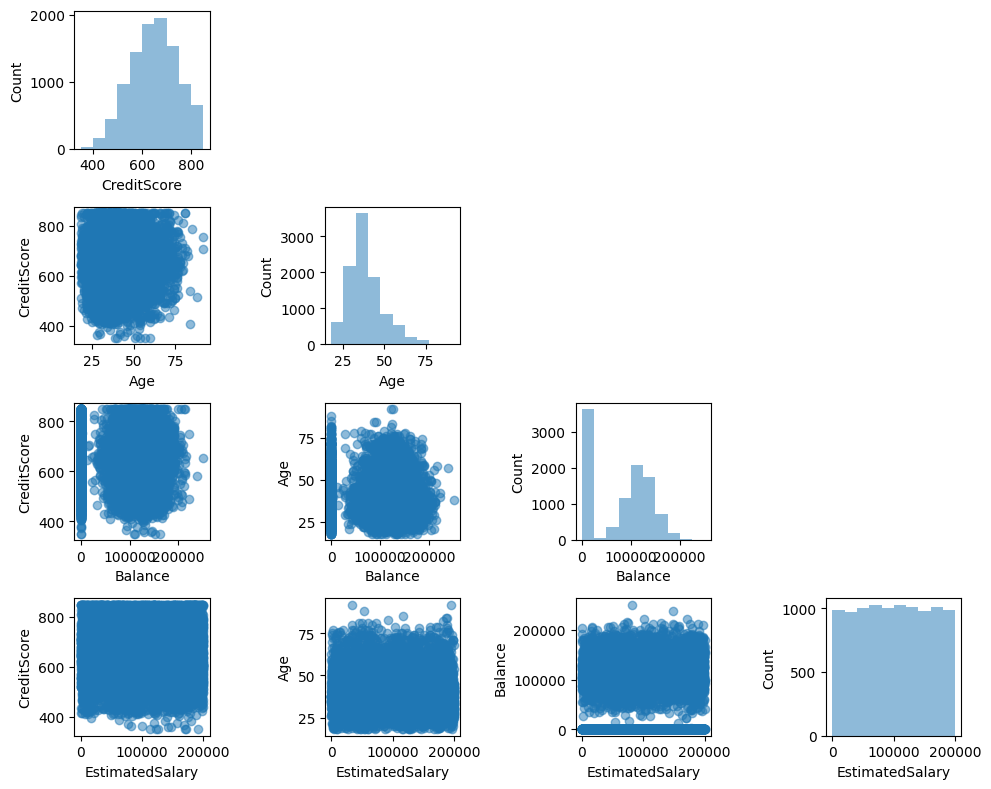

In [60]:
cols_map = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scatterplotmatrix(df[cols_map].values, figsize=(10, 8), alpha=0.5, names=cols_map)

plt.tight_layout()

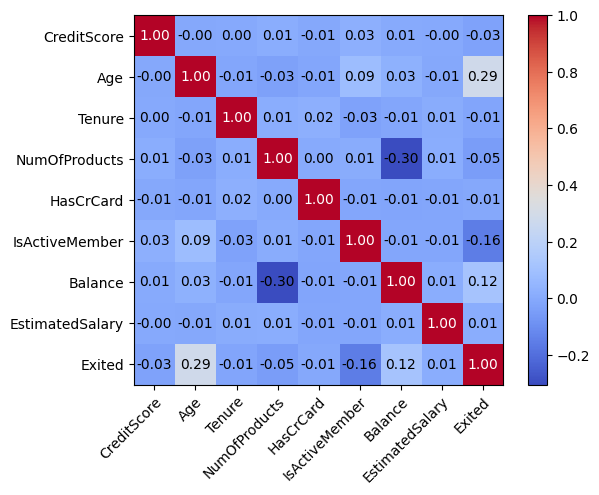

In [61]:
# Shows the correlation matrix
# Apparently there are no features highly correlated (above 0.8 or below -0.8)

cols_corr = ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
             'IsActiveMember', 'Balance', 'EstimatedSalary', 'Exited']

cm = np.corrcoef(df[cols_corr].values.T)
hm = heatmap(cm, row_names=cols_corr, column_names=cols_corr, cmap='coolwarm')

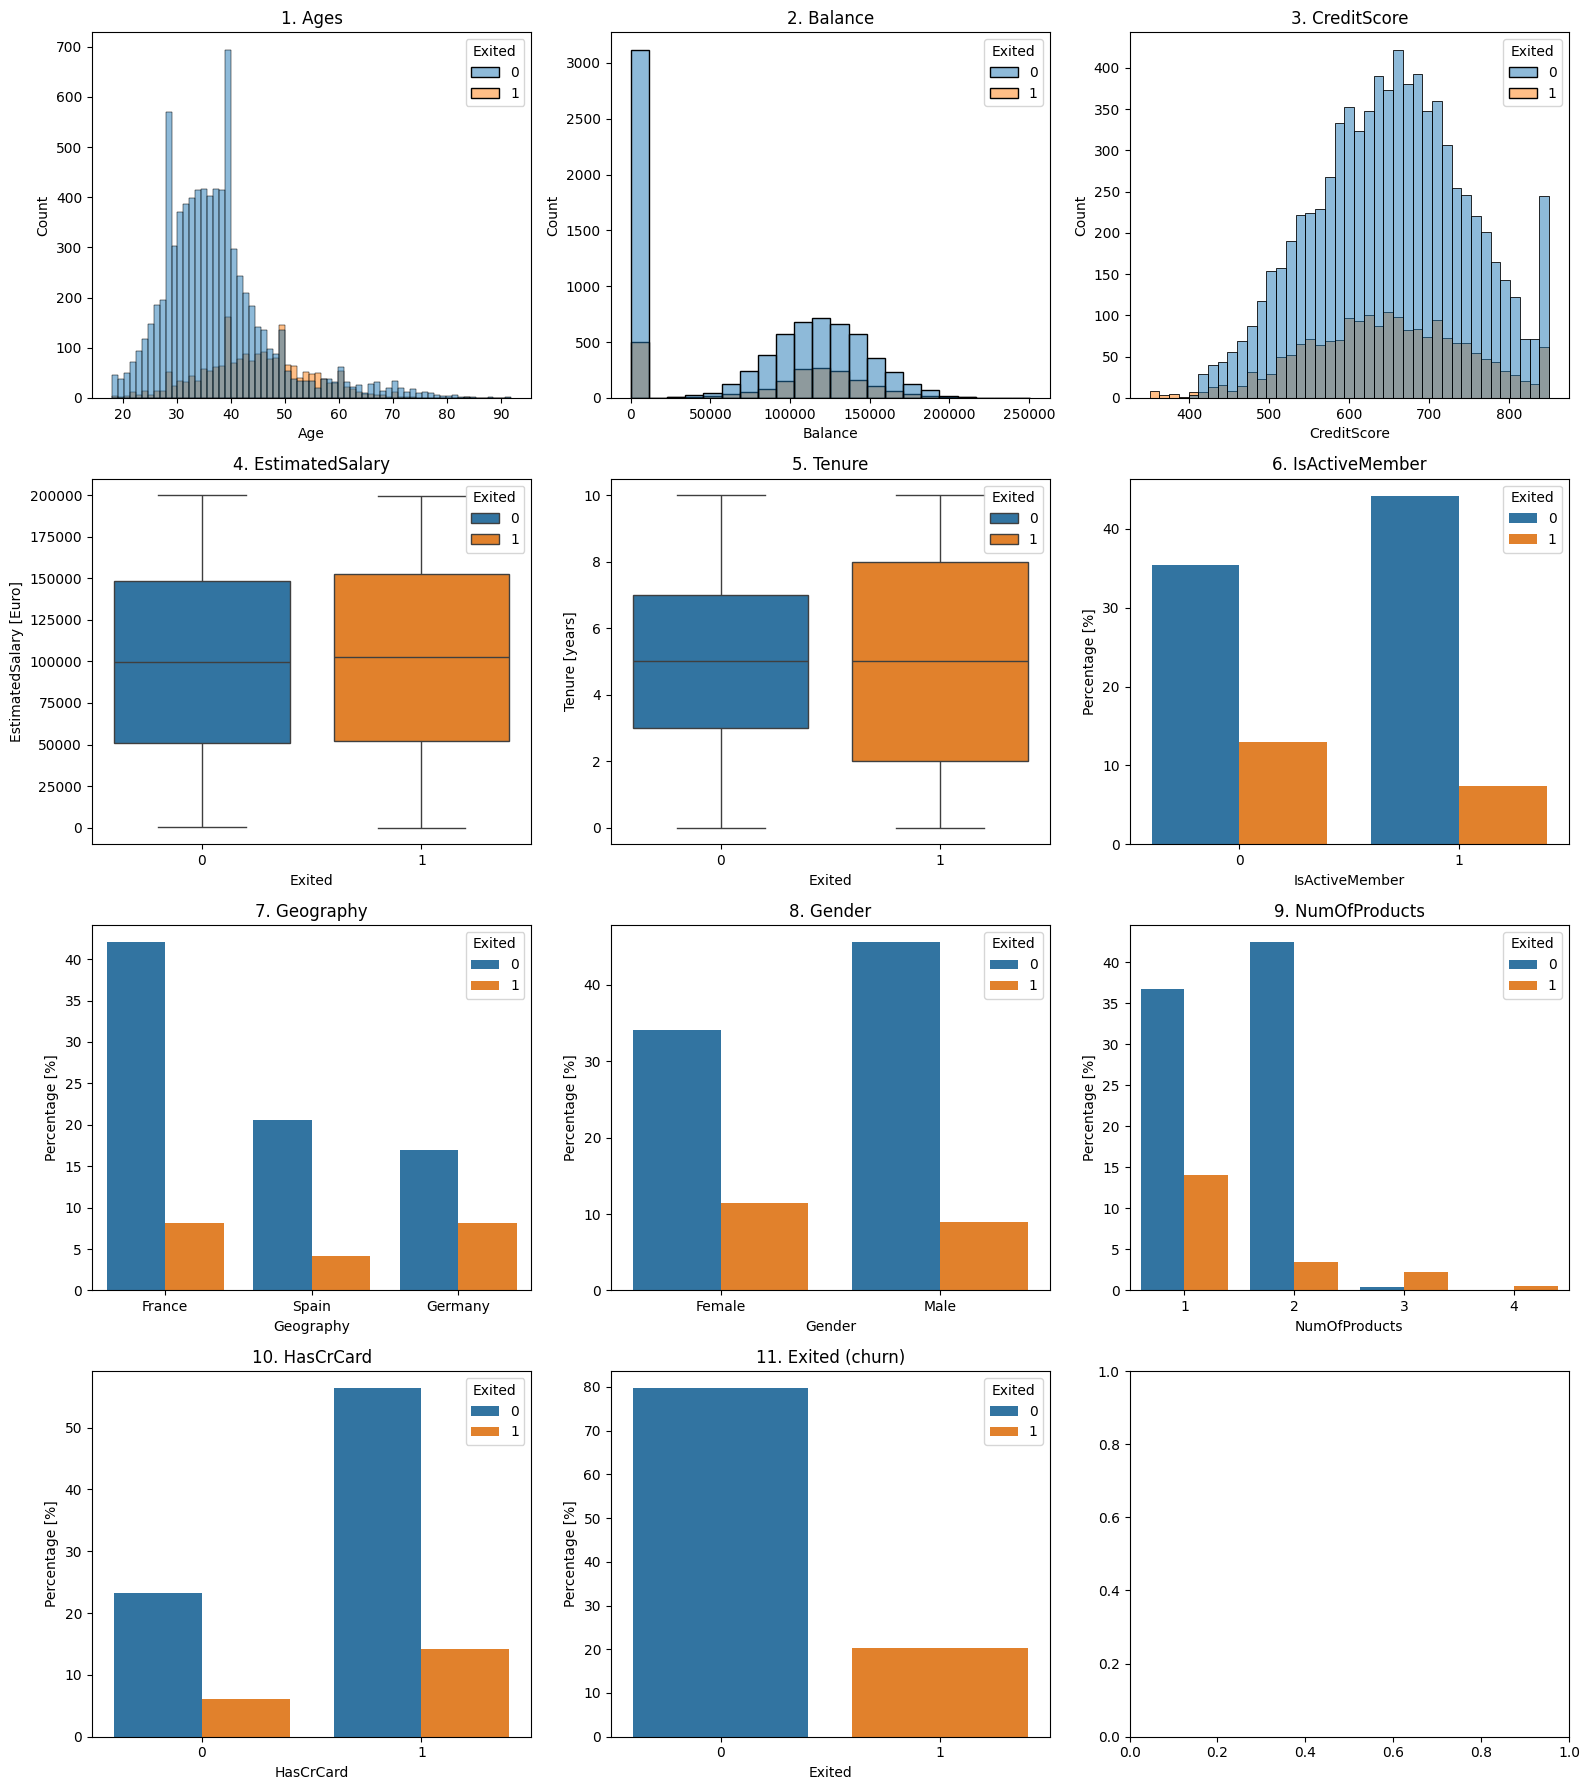

In [62]:
fig, axes = plt.subplots(4, 3, figsize=(16, 18), sharey=False, sharex=False)

# Plotting age distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='Age', hue='Exited', ax=axes[0, 0])
axes[0, 0].set_title('1. Ages')
axes[0, 0].set_ylabel('Count')

# Plotting balance distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='Balance', hue='Exited', ax=axes[0, 1])
axes[0, 1].set_title('2. Balance')
axes[0, 1].set_ylabel('Count')

# Plotting credit score distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='CreditScore', hue='Exited', ax=axes[0, 2])
axes[0, 2].set_title('3. CreditScore')
axes[0, 2].set_ylabel('Count')

# Plotting estimated salary by 'Exited' status.
sns.boxplot(data=df, y='EstimatedSalary', x='Exited', hue='Exited', ax=axes[1, 0])
axes[1, 0].set_title('4. EstimatedSalary')
axes[1, 0].set_ylabel('EstimatedSalary [Euro]')

# Plotting tenure by 'Exited' status.
sns.boxplot(data=df, y='Tenure', x='Exited', hue='Exited', ax=axes[1, 1])
axes[1, 1].set_title('5. Tenure')
axes[1, 1].set_ylabel('Tenure [years]')

# Plotting count of active members, categorized by 'Exited' status.
sns.countplot(data=df, x='IsActiveMember', hue='Exited', ax=axes[1, 2],  stat="percent")
axes[1, 2].set_title('6. IsActiveMember')
axes[1, 2].set_ylabel('Percentage [%]')

# Plotting geography distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='Geography', hue='Exited', ax=axes[2, 0], stat="percent")
axes[2, 0].set_title('7. Geography')
axes[2, 0].set_ylabel('Percentage [%]')

# Plotting gender distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='Gender', hue='Exited', ax=axes[2, 1], stat="percent")
axes[2, 1].set_title('8. Gender')
axes[2, 1].set_ylabel('Percentage [%]')

# Plotting the number of products distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='NumOfProducts', hue='Exited', ax=axes[2, 2], stat="percent")
axes[2, 2].set_title('9. NumOfProducts')
axes[2, 2].set_ylabel('Percentage [%]')

# Plotting credit card ownership, categorized by 'Exited' status.
sns.countplot(data=df, x='HasCrCard', hue='Exited', ax=axes[3, 0], stat="percent")
axes[3, 0].set_title('10. HasCrCard')
axes[3, 0].set_ylabel('Percentage [%]')

# Plotting the number of exited clients
sns.countplot(data=df, x='Exited', hue='Exited', ax=axes[3, 1], stat="percent")
axes[3, 1].set_title('11. Exited (churn)')
axes[3, 1].set_ylabel('Percentage [%]')

plt.tight_layout()


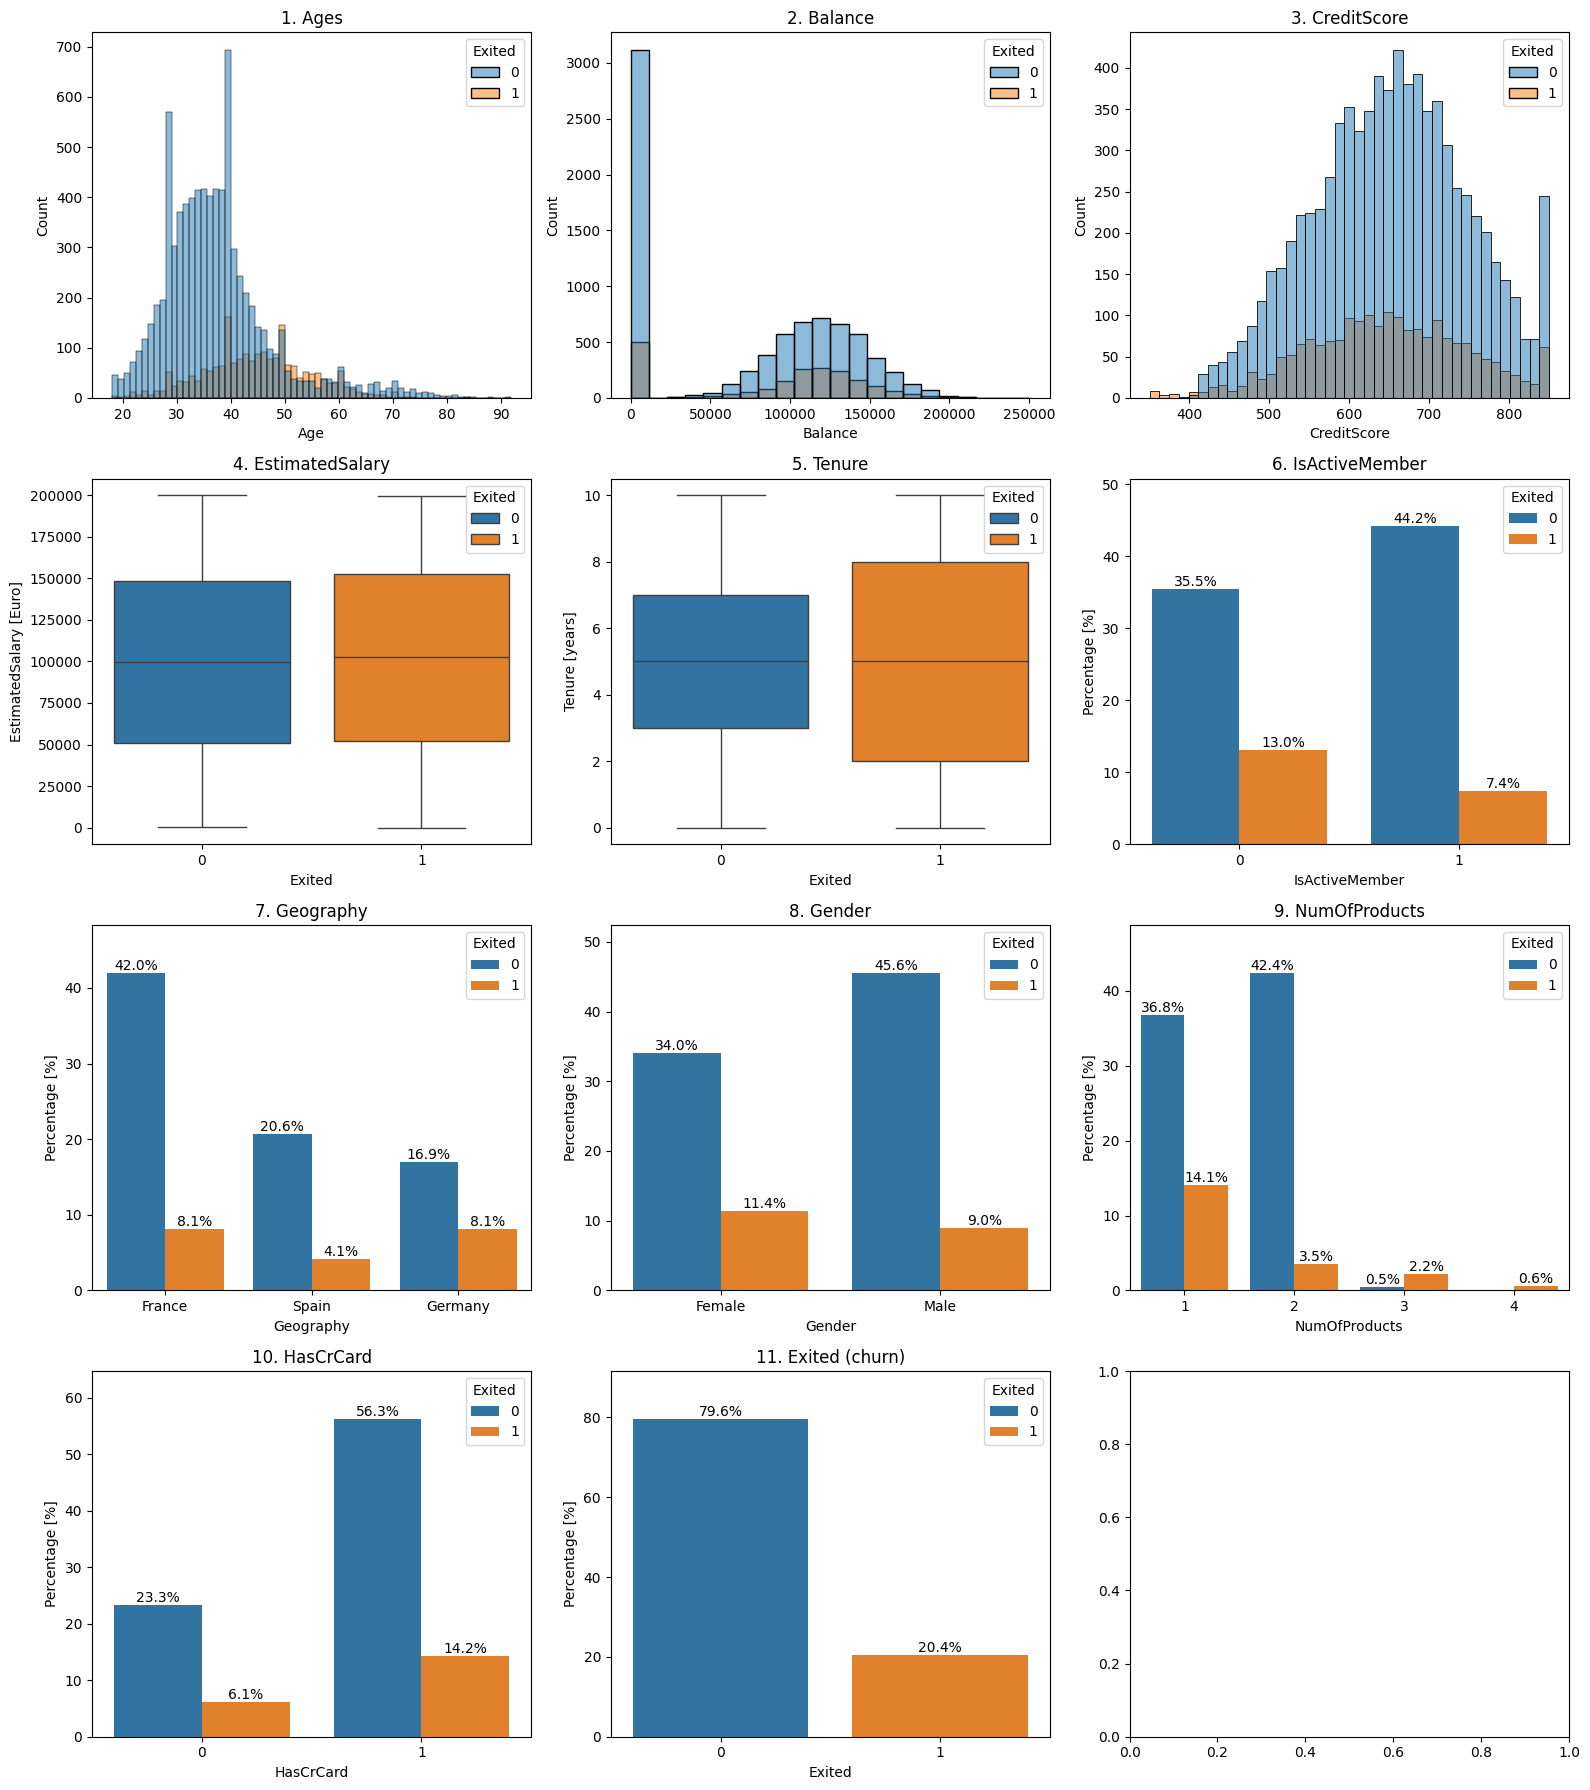

In [63]:
def add_percentage_labels(ax):
    """
    Adds percentage labels to the bars of a countplot.

    Parameters:
    ax (matplotlib.axes.Axes): The axis object of the countplot to which the percentage labels will be added.
    """
    # Calculate the total height of all bars in the plot
    total = sum([patch.get_height() for patch in ax.patches])

    # Find the maximum height of the bars
    max_height = max([patch.get_height() for patch in ax.patches])

    # Set the y-axis limit to provide extra space above the tallest bar
    ax.set_ylim(0, max_height * 1.15)  # Increase y-limit by 15%
    
    # Iterate over each bar (patch) in the axis
    for patch in ax.patches:
        # Get the height of the current bar
        height = patch.get_height()
        
        # Calculate the percentage of the current bar relative to the total
        percentage = height / total * 100
        
        # Add a text label above the bar if the percentage is greater than 0
        if percentage > 0:
            ax.text(
                patch.get_x() + patch.get_width() / 2.,  # X position (center of the bar)
                height,  # Y position (top of the bar)
                f'{percentage:.1f}%',  # Label text (percentage with one decimal place)
                ha='center',  # Horizontal alignment ('center' aligns text in the middle)
                va='bottom',  # Vertical alignment ('bottom' places text just above the bar)
                fontsize=10  # Font size of the label
            )

fig, axes = plt.subplots(4, 3, figsize=(16, 18), sharey=False, sharex=False)

# Plotting age distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='Age', hue='Exited', ax=axes[0, 0])
axes[0, 0].set_title('1. Ages')
axes[0, 0].set_ylabel('Count')

# Plotting balance distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='Balance', hue='Exited', ax=axes[0, 1])
axes[0, 1].set_title('2. Balance')
axes[0, 1].set_ylabel('Count')

# Plotting credit score distribution, categorized by 'Exited' status.
sns.histplot(data=df, x='CreditScore', hue='Exited', ax=axes[0, 2])
axes[0, 2].set_title('3. CreditScore')
axes[0, 2].set_ylabel('Count')

# Plotting estimated salary by 'Exited' status.
sns.boxplot(data=df, y='EstimatedSalary', x='Exited', hue='Exited', ax=axes[1, 0])
axes[1, 0].set_title('4. EstimatedSalary')
axes[1, 0].set_ylabel('EstimatedSalary [Euro]')

# Plotting tenure by 'Exited' status.
sns.boxplot(data=df, y='Tenure', x='Exited', hue='Exited', ax=axes[1, 1])
axes[1, 1].set_title('5. Tenure')
axes[1, 1].set_ylabel('Tenure [years]')

# Plotting count of active members, categorized by 'Exited' status.
sns.countplot(data=df, x='IsActiveMember', hue='Exited', ax=axes[1, 2], stat="percent")
axes[1, 2].set_title('6. IsActiveMember')
axes[1, 2].set_ylabel('Percentage [%]')
add_percentage_labels(axes[1, 2])  # Add percentage labels

# Plotting geography distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='Geography', hue='Exited', ax=axes[2, 0], stat="percent")
axes[2, 0].set_title('7. Geography')
axes[2, 0].set_ylabel('Percentage [%]')
add_percentage_labels(axes[2, 0])  # Add percentage labels

# Plotting gender distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='Gender', hue='Exited', ax=axes[2, 1], stat="percent")
axes[2, 1].set_title('8. Gender')
axes[2, 1].set_ylabel('Percentage [%]')
add_percentage_labels(axes[2, 1])  # Add percentage labels

# Plotting the number of products distribution, categorized by 'Exited' status.
sns.countplot(data=df, x='NumOfProducts', hue='Exited', ax=axes[2, 2], stat="percent")
axes[2, 2].set_title('9. NumOfProducts')
axes[2, 2].set_ylabel('Percentage [%]')
add_percentage_labels(axes[2, 2])  # Add percentage labels

# Plotting credit card ownership, categorized by 'Exited' status.
sns.countplot(data=df, x='HasCrCard', hue='Exited', ax=axes[3, 0], stat="percent")
axes[3, 0].set_title('10. HasCrCard')
axes[3, 0].set_ylabel('Percentage [%]')
add_percentage_labels(axes[3, 0])  # Add percentage labels

# Plotting the number of exited clients
sns.countplot(data=df, x='Exited', hue='Exited', ax=axes[3, 1], stat="percent")
axes[3, 1].set_title('11. Exited (churn)')
axes[3, 1].set_ylabel('Percentage [%]')
add_percentage_labels(axes[3, 1])  # Add percentage labels

plt.tight_layout()
plt.show()


In [64]:
# Churned people tend to be older
# Churned people tend to be less active (higher porportion of churned when IsActiveMember=0)
# There is no visible difference between churned = 0 and churned = 1
# About 80% of non exited and 20% of exited client. The dataset is not balanced. We can assume that churn rate is approximately 20%.

#### 2.2 Data preparation

In [65]:
# Drop unncessary columns for modelling ('RowNumber', 'CustomerId', 'Surname')

cols_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(cols_drop, axis=1)

In [34]:
# Perform onehot encoding on categorical columns

categorical_vars = ['Geography', 'Gender']

one_hot_encoder = OneHotEncoder(sparse_output=False, drop = "first")
encoder_vars_array  = one_hot_encoder.fit_transform(df[categorical_vars])

# create object for the feature names using the categorical variables
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create a dataframe to hold the one hot encoded variables
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)

# concatenate the new dataframe back to the original input variables dataframe
df = pd.concat([df.reset_index(drop=True), encoder_vars_df.reset_index(drop=True)], axis = 1)

# drop the original input 2 and input 3 as it is not needed anymore
df.drop(categorical_vars, axis = 1, inplace = True)

In [35]:
# Separate the dataset into features and target

col_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
                'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
col_target = ['Exited']

X = df[col_features]
y = df[col_target]

In [36]:
# Create a balanced dataset as only 20% of rows have 'Exited' = 1
# Upsampling

X_churned = X[(y==1).values]
y_churned = y[(y==1).values]

X_upsampled, y_upsampled = resample(X_churned, y_churned, n_samples=(y['Exited']==0).sum())

X_bal = pd.concat([X[(y==0).values], X_upsampled])
y_bal = pd.concat([y[(y==0).values], y_upsampled])

### 3. Modelling

#### 3.1 Preprocecssing

In [37]:
# Split the balanced data into train and test set

X_train, X_test, y_train, y_test = train_test_split(X_bal, 
                                                    y_bal, 
                                                    test_size=0.3,
                                                    stratify=y_bal)

In [38]:
# Standardize the input to bring to the same scale

stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

#### 3.2 Feature selection

In [39]:
# There are 3 methods of feature selection: wrapper, filter and embedded

# wrapper: evaluate the subset of features by adding or removing features from them --> forward selection, backward selection
# filter: analyse the performance of the feature independently based on statistical / mathematical criterion --> ANOVA, chi-square 
# embedded: incorporate feature selection process into training process --> lasso, ridge, elastic net, decision tree

# The problem of having lots features is that it can lead to the curse of dimensionality that might lead to overfitting of the model.

In [40]:
# As there are 11 features, we´ll evaluate which ones are more important than others using RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
# Display the feature importance in a tabular format

df_importance = pd.DataFrame(index=np.array(X_bal.columns), 
                             data=forest.feature_importances_, 
                             columns=['feature_importance'])

df_importance.sort_values('feature_importance', ascending=False)

,feature_importance
Age,0.256627
Balance,0.145351
EstimatedSalary,0.139807
CreditScore,0.132147
NumOfProducts,0.127808
Tenure,0.079406
IsActiveMember,0.039496
Geography_Germany,0.028577
Gender_Male,0.020056
HasCrCard,0.017656


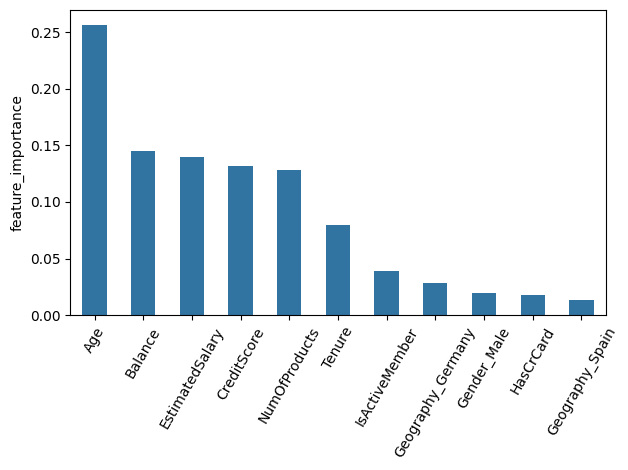

In [42]:
fig, axes = plt.subplots(1, 1)


sns.barplot(data=df_importance['feature_importance'].sort_values(ascending=False), width = 0.5)
plt.xticks(rotation=60)

plt.tight_layout()

#### 3.3 Model selection

In [24]:
# We should evaluate the performance of some models:
# 1. Logistic Regression --> Simple model and easy to explain
# 2. Random Forest --> Model that tends to reduce overfitting by training the dataset on multiple trees
# 3. XGBoost --> Powerful boosting method widely used in a classification problem

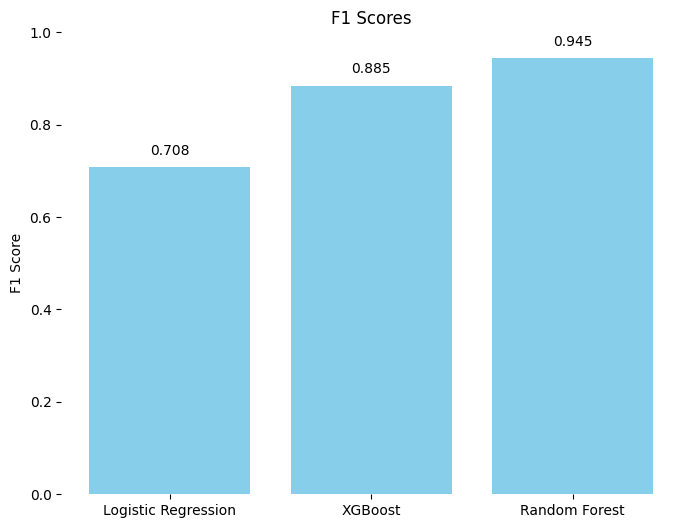

In [43]:
def plot_f1_scores(X_train, X_test, y_train, y_test):
    """
    Trains LogisticRegression, XGBClassifier, and RandomForestClassifier models,
    and plots a vertical bar plot of the F1 scores for each model.

    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels

    Returns:
    - Displays a bar plot of F1 scores for each model.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    f1_scores = {}

    # Train models and compute F1 scores
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1_scores[model_name] = report['weighted avg']['f1-score']  # Store weighted avg F1-score

    # Plotting the F1 scores
    plt.figure(figsize=(8, 6))
    bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores')
    plt.ylim(0, 1)  # Set the y-axis limits to show F1 score range (0 to 1)

    # Remove the top, left, and right spines (axes)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    # Display the F1 score above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom')

    plt.show()


plot_f1_scores(X_train_std, X_test_std, y_train, y_test)

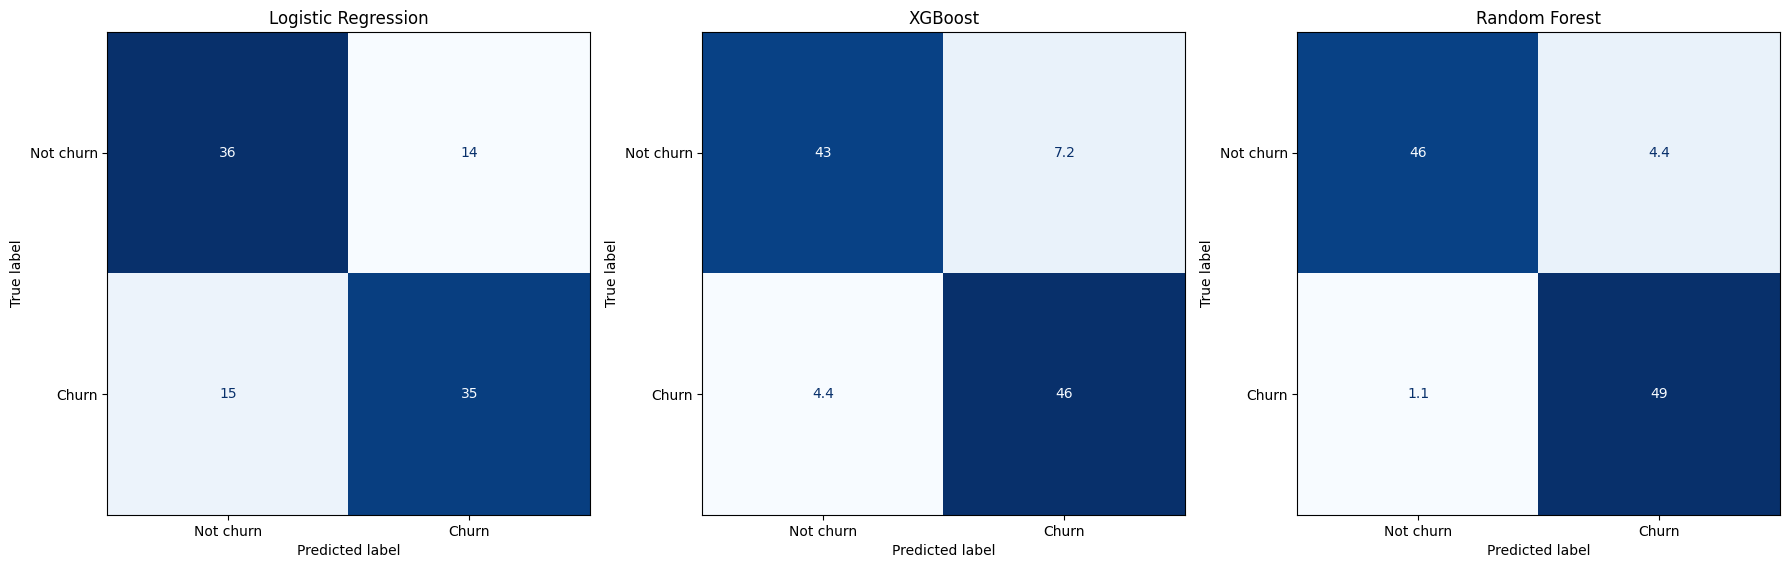

In [44]:
def plot_confusion_matrices(X_train, X_test, y_train, y_test):
    """
    Trains LogisticRegression, XGBClassifier, and RandomForestClassifier models,
    and plots their confusion matrices side by side.

    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels

    Returns:
    - Displays confusion matrices for each model.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (model_name, model) in zip(axes, models.items()):
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict labels
        y_pred = model.predict(X_test)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm*100/y_test.shape[0], display_labels=np.array(['Not churn', 'Churn']))
        disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
        ax.set_title(model_name)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_confusion_matrices(X_train_std, X_test_std, y_train, y_test)

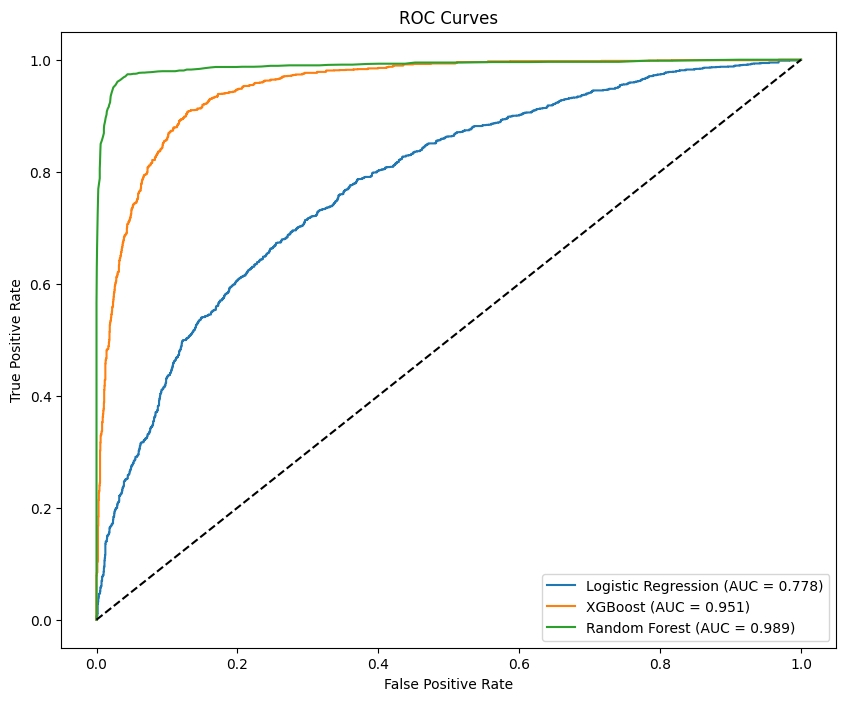

In [45]:
def plot_roc_curves(X_train, X_test, y_train, y_test):
    """
    Trains LogisticRegression, XGBClassifier, and RandomForestClassifier models, 
    and plots their ROC curves.

    Parameters:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training labels
    - y_test: Test labels

    Returns:
    - Plots ROC curves for each model.
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'Random Forest': RandomForestClassifier(n_estimators=100)
    }

    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC-AUC
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

    # Plotting the random guessing line
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curves(X_train_std, X_test_std, y_train, y_test)

In [46]:
# The Random Forest model might be interesting to use in this particular case.
# However, it is also fundamental to assess the performance using k-fold cross validation as the 
# it is sensitive to the way the dataset was split

# Standardize the input to bring to the same scale
stdsc = StandardScaler()

X_train_std_cv = stdsc.fit_transform(X_bal)

# Get the score for each fold using RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
kfold = StratifiedKFold(n_splits=10).split(X_train_std_cv, y_bal)


scoring = scoring = {'acc': 'accuracy',
                    'f1_score': 'f1',
                    'roc_auc': 'roc_auc'}
scores = cross_validate(model, X_train_std_cv, y_bal, scoring=scoring, cv=kfold)

In [47]:
# Number of folds
num_folds = len(scores['test_acc'])

print("Performance on each fold:")

# Print performance metrics for each fold
for i in range(num_folds):
    print(f'Fold k={i+1}: acc = {scores["test_acc"][i]:.8f}, f1 = {scores["test_f1_score"][i]:.8f},  roc_auc = {scores["test_roc_auc"][i]:.8f}')
    
# Calculate mean and standard deviation for each metric
acc_mean = np.mean(scores['test_acc'])
acc_std = np.std(scores['test_acc'])
f1_mean = np.mean(scores['test_f1_score'])
f1_std = np.std(scores['test_f1_score'])
roc_auc_mean = np.mean(scores['test_roc_auc'])
roc_auc_std = np.std(scores['test_roc_auc'])

# Print mean and standard deviation
print("\nSummary statistics:")
print(f'Mean Accuracy: {acc_mean:.3f}, Std Accuracy: {acc_std:.3f}')
print(f'Mean F1 Score: {f1_mean:.3f}, Std F1 Score: {f1_std:.3f}')
print(f'Mean ROC AUC: {roc_auc_mean:.3f}, Std ROC AUC: {roc_auc_std:.3f}')

Performance on each fold:
Fold k=1: acc = 0.96045198, f1 = 0.96165551,  roc_auc = 0.99612870
Fold k=2: acc = 0.96170747, f1 = 0.96269113,  roc_auc = 0.99681437
Fold k=3: acc = 0.95417451, f1 = 0.95546065,  roc_auc = 0.99256713
Fold k=4: acc = 0.97112367, f1 = 0.97163995,  roc_auc = 0.99486375
Fold k=5: acc = 0.95856874, f1 = 0.96000000,  roc_auc = 0.99546903
Fold k=6: acc = 0.96170747, f1 = 0.96291793,  roc_auc = 0.99639982
Fold k=7: acc = 0.95163317, f1 = 0.95296274,  roc_auc = 0.99281426
Fold k=8: acc = 0.95979899, f1 = 0.96083231,  roc_auc = 0.99189178
Fold k=9: acc = 0.96293970, f1 = 0.96400244,  roc_auc = 0.99632980
Fold k=10: acc = 0.95728643, f1 = 0.95828221,  roc_auc = 0.99112396

Summary statistics:
Mean Accuracy: 0.960, Std Accuracy: 0.005
Mean F1 Score: 0.961, Std F1 Score: 0.005
Mean ROC AUC: 0.994, Std ROC AUC: 0.002


#### 3.4 Model tuning

In [48]:
# The result of the session '3.4 MOdel selection' shows that RandomForestClassifier might be a good choice for this case
# Now we can jump to 'Model tunig' to tune the hyperparameter of this model
# Some important hyperparamters of RandomForestClassifier are: n_estimators, max_features, min_samples_split


# Number of trees in random forest
n_estimators = [10, 50, 100]

# Number of features to consider at every split
max_features = ['sqrt', 5]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

param = param_grid = {'n_estimators': n_estimators, 
                      'max_features': max_features,
                      'min_samples_split': min_samples_split}

In [49]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Evaluation metric
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search.fit(X_train_std, y_train)

# Best parameters found
print(f'Best Parameters: {random_search.best_params_}')

# Best estimator
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_std)
y_pred_proba = best_rf.predict_proba(X_test_std)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test ROC AUC Score: {test_roc_auc:.4f}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'max_features': 5}
Test Accuracy: 0.9408
Test F1 Score: 0.9427
Test ROC AUC Score: 0.9871


In [50]:
# The best parameter (n_estimator = 50) has lower number of trees than the default one  (n_estimator = 100) in random forest.

# It is advantageous to use this instead of the default one because:
# 1. The performance is slightly better when n_estimators = 50
# 2. The processing time will decrease as larger trees requires more computational resource to process the data

In [51]:
# Not let´s save the model in MLflow